In [33]:
import numpy as np 
import pandas as pd 
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [34]:
#### indexing review ####
np_array = np.random.randn(9,5)
tensor = torch.randn(9,5)
df_v1 = pd.DataFrame(
    np.random.randn(9,5),
    columns = ['col1', 'col2', 'col3','col4', 'col5']
)
df_v2 = pd.DataFrame(
    {
        'colA': np.random.randn(9),
        'colB': np.random.randn(9),
        'colC': np.random.randn(9),
        'colD': np.random.randint(1,10,(9,)),
        'colE': np.random.randint(1,10,(9,)),
    }
)

In [35]:
np_array[2,3]
np_array[2:4,2:4]
np_array[2:4]
np_array[:, 2:4]

tensor[2,3]
tensor[2:4,2:4]
tensor[2:4]
np_array[:, 2:4]

df_v1.iloc[2,3]
df_v1.iloc[2:4, 2:4]
df_v1.iloc[:, 2:4]
df_v1.iloc[2:4]

df_v2.loc[3:6, 'colA': 'colC']
df_v2.loc[3:6]
df_v2.loc[:,'colA': 'colC']

,colA,colB,colC
0,1.503245,-0.153253,1.733755
1,1.078352,0.734621,1.314633
2,1.477288,2.320548,-1.986383
3,-0.205939,0.282013,0.395638
4,-0.359805,-0.843519,0.944741
5,-1.142456,1.071017,0.204863
6,-1.379384,0.501918,1.273364
7,0.099126,-1.741246,1.347586
8,0.967847,-0.292390,0.041956


In [36]:
#### Load the names.txt & Read Basic Information ####
words = open('makemore/names.txt', 'r').read().splitlines()
print(words[:10])
print(len(words))
word_len = [min(len(w) for w in words), max(len(w) for w in words)]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
32033


In [37]:
#### Build the Char/Num & Num/Char Correspondance ####
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [38]:
#### build the dataset #### 

block_size = 3
X = []
y = []
words = [w + '.' for w in words]
for word in words:
    context = [0] * block_size
    for char in word:
        idx = stoi[char]
        X.append(context)
        y.append(idx)
        context = context[1:] + [idx]

X = torch.Tensor(X)
y = torch.Tensor(y)
print(X.size())
print(y.size())

torch.Size([228146, 3])
torch.Size([228146])


In [39]:
print('top 4 tensors in X:') 
print(X[:4])
print('top 4 tensors in y:')
print(y[:4])

top 4 tensors in X:
tensor([[ 0.,  0.,  0.],
        [ 0.,  0.,  5.],
        [ 0.,  5., 13.],
        [ 5., 13., 13.]])
top 4 tensors in y:
tensor([ 5., 13., 13.,  1.])


In [40]:
#### make the build_dataset function ####

def build_dataset(block_size, words):
    X = []
    y = []
    for word in words:
        context = [0] * block_size
        for char in word:
            idx = stoi[char]
            X.append(context)
            y.append(idx)
            context = context[1:] + [idx]
    
    X = torch.Tensor(X)
    y = torch.Tensor(y)

    return X, y


random.seed(0)
random.shuffle(words)
tr_threshold = int(0.70 * len(words))
val_threshold = int(0.85 * len(words))

X_tr, y_tr = build_dataset(3, words[:tr_threshold])
X_val, y_val = build_dataset(3, words[tr_threshold:val_threshold])
X_te, y_te =  build_dataset(3, words[val_threshold:])



In [41]:
X_tr = X_tr.long()
y_tr = y_tr.long()
X_val = X_val.long()
y_val = y_val.long()
X_te = X_te.long()
y_te = y_te.long()

In [42]:
print(X_tr.size(), y_tr.size())
print(X_val.size(), y_val.size())
print(X_te.size(), y_te.size())

torch.Size([159766, 3]) torch.Size([159766])
torch.Size([34256, 3]) torch.Size([34256])
torch.Size([34124, 3]) torch.Size([34124])


In [43]:
print(X.dtype, y.dtype)
X = X.long() 
y = y.long()
print(X.dtype, y.dtype)

torch.float32 torch.float32
torch.int64 torch.int64


In [44]:
#### Initialize the embedding vector for all characters ####
g = torch.Generator().manual_seed(0)

char_embedding = torch.randn((27,10))
w1 = torch.randn((30, 200), generator = g, requires_grad = True)
b1 = torch.randn(200, generator = g, requires_grad = True)
w2 = torch.randn((200, 60), generator = g, requires_grad = True)
b2 = torch.randn(60, generator = g, requires_grad = True)
w3 = torch.randn((60, 27), generator = g, requires_grad = True)
b3 = torch.randn(27, generator = g, requires_grad = True)
parameters = [w1, b1, w2, b2, w3, b3]


In [45]:
sum(p.nelement() for p in parameters)

19907

In [46]:
#### Iteration-based mini-batch GD function ####
steps = []
losses = []

for i in range(20000):
    idx_list = torch.randint(0, X_tr.shape[0], (32,))
    
    Xemb = char_embedding[X_tr[idx_list]]
    Xemb = Xemb.view(-1, 30)
    z1 = Xemb @ w1 + b1 
    a1 = torch.tanh(z1)

    z2 = a1 @ w2 + b2 
    a2 = torch.tanh(z2)

    logits = a2 @ w3 + b3 
    loss = F.cross_entropy(logits, y_tr[idx_list])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1
    for p in parameters:
        p.data += -1 * p.grad * lr
    
    steps.append(i)
    losses.append(loss.log10().item())


In [47]:
XtrEmb = char_embedding[X_tr].view(-1,30)
a1 = torch.tanh(XtrEmb @ w1 + b1)
a2 = torch.tanh(a1 @ w2 + b2)
logits = a2 @ w3 + b3
loss = F.cross_entropy(logits, y_tr)
print('training loss:')
print(loss)

training loss:
tensor(2.2975, grad_fn=<NllLossBackward0>)


In [48]:
XvalEmb = char_embedding[X_val].view(-1,30)
a1 = torch.tanh(XvalEmb @ w1 + b1)
a2 = torch.tanh(a1 @ w2 + b2)
logits = a2 @ w3 + b3
loss = F.cross_entropy(logits, y_val)
print('validation loss:')
print(loss)

validation loss:
tensor(2.3507, grad_fn=<NllLossBackward0>)


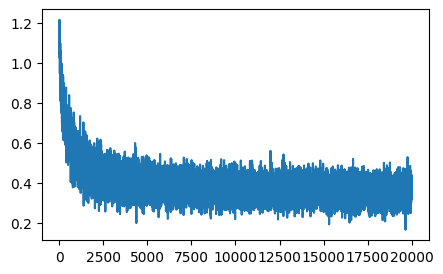

In [49]:
plt.figure(figsize = (5,3))
plt.plot(steps, losses)

In [50]:
#### Epoch-based mini-batch GD function ####
steps_new = []
losses_new = []

batch_size = 32
epochs = 10

for epoch in range(epochs):
    
    idx_random = torch.randperm(X_tr.shape[0])

    for i in range(0,X_tr.shape[0], batch_size):
        idx_list = idx_random[i:i+batch_size]
        Xemb = char_embedding[X_tr[idx_list]].view(-1,30)
        a1 = torch.tanh(Xemb @ w1 + b1)
        a2 = torch.tanh(a1 @ w2 + b2)
        logits = a2 @ w3 + b3 
        loss = F.cross_entropy(logits, y_tr[idx_list])

        for p in parameters:
            p.grad = None
        loss.backward()

        lr = 0.1
        for p in parameters:
            p.data += -1 * p.grad * lr

        steps_new.append(i)
        losses_new.append(loss.log10().item())


In [51]:
print('training loss:')
print(loss.item())

training loss:
2.258943557739258


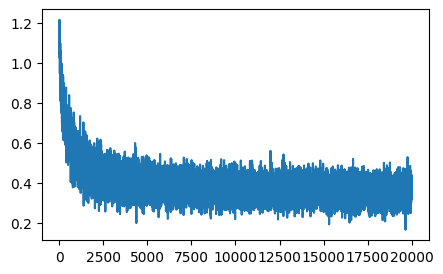

In [52]:
plt.figure(figsize = (5,3))
plt.plot(steps, losses)

In [53]:
XtrEmb = char_embedding[X_tr].view(-1,30)
a1 = torch.tanh(XtrEmb @ w1 + b1)
a2 = torch.tanh(a1 @ w2 + b2)
logits = a2 @ w3 + b3
loss = F.cross_entropy(logits, y_tr)
print('training loss:')
print(loss)

training loss:
tensor(2.2060, grad_fn=<NllLossBackward0>)


In [54]:
XvalEmb = char_embedding[X_val].view(-1,30)
a1 = torch.tanh(XvalEmb @ w1 + b1)
a2 = torch.tanh(a1 @ w2 + b2)
logits = a2 @ w3 + b3
loss = F.cross_entropy(logits, y_val)
print('validation loss:')
print(loss)

validation loss:
tensor(2.2764, grad_fn=<NllLossBackward0>)


In [55]:
print('the x and y coordiates for H:')
print(char_embedding[8,0].item(), char_embedding[8,1].item())

the x and y coordiates for H:
0.6047860383987427 -1.2123769521713257


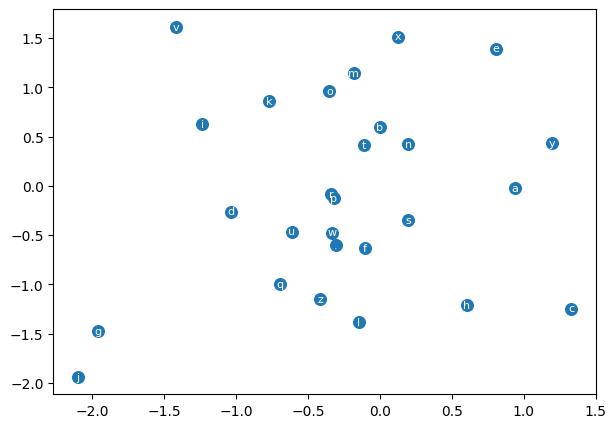

In [56]:
plt.figure(figsize = (7,5))
plt.scatter(char_embedding[:,0], char_embedding[:,1], s=70)
for i in range(char_embedding.shape[0]):
    plt.text(char_embedding[i,0].item(), char_embedding[i,1].item(), itos[i], ha = 'center', va = 'center', color = 'white', fontsize = 8)


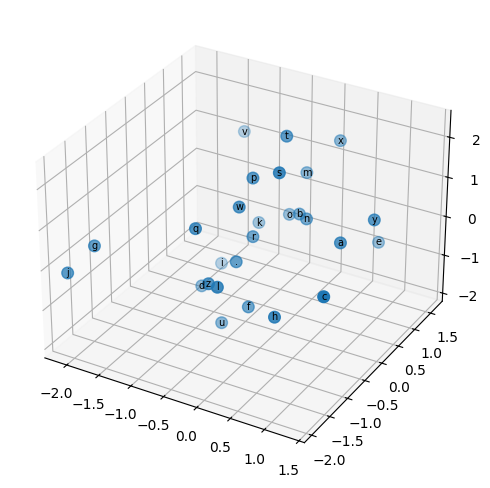

In [57]:
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(char_embedding[:,0], char_embedding[:,1], char_embedding[:,2], s = 70)
for i in range(char_embedding.shape[0]):
    ax.text(char_embedding[i,0], char_embedding[i,1], char_embedding[i,2], itos[i], ha = 'center', va = 'center', fontsize = 7)

In [59]:
g = torch.Generator().manual_seed(0)
block_size = 3

new_names = []
for _ in range(10):
    name_created = []
    context = [0] * block_size

    while True:
        Xemb = char_embedding[context].view(-1,30)
        a1 = torch.tanh(Xemb @ w1 + b1) 
        a2 = torch.tanh(a1 @ w2 + b2) 
        logits = a2 @ w3 + b3 
        probs = F.softmax(logits, dim = 1)
        idx = torch.multinomial(probs, num_samples = 1, generator = g).item()
        name_created.append(idx)
        context = context[1:] + [idx]
        if idx == 0:
            break

    curr_name = ''.join([itos[idx] for idx in name_created])
    new_names.append(curr_name)

print(new_names)


['brrer.', 'kerin.', 'marenli.', 'lem.', 'azvitiyah.', 'henn.', 'landretrer.', 'juni.', 'atty.', 'zadelynna.']
